The Goblet of Fire

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random 
from enum import Enum
import sys
from collections import deque
import pygame
from os import path

In the following code snippet I have defined all the constants used and also set a random starting position for harry , death eater and the cup.

In [2]:
EpisodeNum=20000
MOVE_PENALTY=-1
ENEMY_PENALTY=-100
CUP_REWARDS=100
epsilon=1
epsilon_min=0.05
discount=0.9

epsilon_decay=0.995
class Action(Enum):
    LEFT=0
    DOWN=1
    RIGHT=2
    UP=3

#This class is used to represent the object on the grid
class GridTile(Enum):
    _FLOOR =0
    AGENT=1
    TARGET=2
    ENEMY=3
    XWALL=4

    def __str__(self):
        return self.name[:1] #Gives the first letter of the object

colourdict={1:(255,175,0),2:(0,255,0),3:(0,0,255)}

map=["XXXXXXXXXXXXXXX",
     "X         X   X",
     "X XX X X XX   X",
     "X         X   X",
     "X X  XX XX  X X",
     "X    X  X X X X",
     "X    X      X X",
     "X X  XX X     X",
     "X             X",
     "XXXXXXXXXXXXXXX"]
intmap=[]
for string in map:
    arr=[]
    for char in string:
        if(char=="X"):
            arr.append(1)
        else:
            arr.append(0)
    intmap.append(arr)


assigned=False
harry_pos=[]
DE_pos=[]
Cup_pos=[]
random.seed(1)
while not assigned:
    harry_pos=[random.randint(0,9),random.randint(0,14)]
    if intmap[harry_pos[0]][harry_pos[1]] !=1:
        assigned = True
assigned=False
while not assigned:
    DE_pos=[random.randint(0,9),random.randint(0,14)]
    if intmap[DE_pos[0]][DE_pos[1]] !=1:
        assigned = True
assigned=False
while not assigned:
    Cup_pos=[random.randint(0,9),random.randint(0,14)]
    if intmap[Cup_pos[0]][Cup_pos[1]] !=1:
        assigned = True

print("Harry starting position:- "+str(harry_pos))
print("Death eater starting position"+str(DE_pos))
print("Cup starting position"+str(Cup_pos))
# Print state at the starting
for r in range(10):
    for c in range(15):

        if([r,c] ==harry_pos):
            print(GridTile.AGENT, end=' ')
        elif([r,c] == Cup_pos):
            print(GridTile.TARGET, end=' ')
        elif([r,c]==DE_pos):
            print(GridTile.ENEMY, end=' ')
        elif(intmap[r][c]==1):
            print(GridTile.XWALL, end=' ')
        else:
            print(GridTile._FLOOR, end=' ')
    print() 
print() 










Harry starting position:- [1, 4]
Death eater starting position[1, 7]
Cup starting position[7, 7]
X X X X X X X X X X X X X X X 
X _ _ _ A _ _ E _ _ X _ _ _ X 
X _ X X _ X _ X _ X X _ _ _ X 
X _ _ _ _ _ _ _ _ _ X _ _ _ X 
X _ X _ _ X X _ X X _ _ X _ X 
X _ _ _ _ X _ _ X _ X _ X _ X 
X _ _ _ _ X _ _ _ _ _ _ X _ X 
X _ X _ _ X X T X _ _ _ _ _ X 
X _ _ _ _ _ _ _ _ _ _ _ _ _ X 
X X X X X X X X X X X X X X X 



Code to implement breadth first search algorithm

In [3]:
Directions=[(-1,0),(1,0),(0,-1),(0,1)]
def is_valid(x,y):
    return intmap[x][y]==0 
def bfs(start,goal):
    queue=deque([(start,[])])
    visited =set()
    visited.add(start)
    while queue:
        (x,y),path=queue.popleft()
        if(x,y)==goal:
            return path+[(x,y)]
        for dx,dy in Directions:
            nx,ny=x+dx,y+dy
            if is_valid(nx,ny) and (nx,ny) not in visited:
                visited.add((nx,ny))
                queue.append(((nx,ny),path+[(x,y)]))
    return None

start=(DE_pos[0],DE_pos[1])
goal=(harry_pos[0],harry_pos[1])
shortest_path=bfs(start,goal)
if shortest_path:
    print("Shortest path found:")
    for step in shortest_path:
        print(step)
else:
    print("No path found.")

Shortest path found:
(1, 7)
(1, 6)
(1, 5)
(1, 4)


Then we model the problem so that we can convert into an evironment

In [4]:

#class to create the Maze
class Maze:
    def __init__(self,grid_rows=10,grid_cols=15,fps=1):
        self.grid_rows=grid_rows
        self.grid_cols=grid_cols
        self.reset()
        # self._init_pygame()
        self.last_action=' '
        self.fps=fps
    
    # def _init_pygame(self):
    #     pygame.init() # initialize pygame
    #     pygame.display.init() # Initialize the display module

    #     # Game clock
    #     self.clock = pygame.time.Clock()

    #     # Default font
    #     self.action_font = pygame.font.SysFont("Calibre",30)
    #     self.action_info_height = self.action_font.get_height()

    #     # For rendering
    #     self.cell_height = 64
    #     self.cell_width = 64
    #     self.cell_size = (self.cell_width, self.cell_height)        

    #     # Define game window size (width, height)
    #     self.window_size = (self.cell_width * self.grid_cols, self.cell_height * self.grid_rows + self.action_info_height)

    #     # Initialize game window
    #     self.window_surface = pygame.display.set_mode(self.window_size) 

    #     # Load & resize sprites
    #     file_name = "harrypotter.png"
    #     img = pygame.image.load(file_name)
    #     self.harry_img = pygame.transform.scale(img, self.cell_size)

    #     file_name = "floor.png"
    #     img = pygame.image.load(file_name)
    #     self.floor_img = pygame.transform.scale(img, self.cell_size)

    #     file_name =  "trophy.png"
    #     img = pygame.image.load(file_name)
    #     self.cup_img = pygame.transform.scale(img, self.cell_size) 

    #     file_name = "wall.png"
    #     img = pygame.image.load(file_name)
    #     self.wall_img = pygame.transform.scale(img, self.cell_size) 

    #     file_name = "deatheater.png"
    #     img = pygame.image.load(file_name)
    #     self.deatheater_img = pygame.transform.scale(img, self.cell_size) 

        
    def reset(self):
        self.agent_pos=harry_pos
        self.cup_pos=Cup_pos
        self.enemy_pos=DE_pos
    
    def perform_action(self,agent_action:Action):
        self.last_action = agent_action
        new=[]

        if agent_action == Action.LEFT:
            new=[self.agent_pos[0],self.agent_pos[1]-1]
        elif agent_action == Action.RIGHT:
            new=[self.agent_pos[0],self.agent_pos[1]+1]
        elif agent_action == Action.UP:
            new=[self.agent_pos[0]-1,self.agent_pos[1]]
        elif agent_action == Action.DOWN:
            new=[self.agent_pos[0]+1,self.agent_pos[1]]
        
        if(intmap[new[0]][new[1]]==0):
            self.agent_pos=new 
        if(self.agent_pos==self.enemy_pos):
            return "CAPTURED"  
        start=(self.enemy_pos[0],self.enemy_pos[1])
        goal=(self.agent_pos[0],self.agent_pos[1])
        shortest_path=bfs(start,goal)
        self.enemy_pos=[shortest_path[1][0],shortest_path[1][1]]
        if(self.agent_pos==self.enemy_pos):
            return "CAPTURED" 
        if(self.agent_pos==self.cup_pos):
            return "WIN"
        else:
            return "SAFE"

        
        
        
             
        # return self.agent_pos == self.target_pos #Returns true if agent reaches target
    
    def render(self):
        # Print current state
        for r in range(10):
            for c in range(15):

                if([r,c] ==self.agent_pos):
                    print(GridTile.AGENT, end=' ')
                elif([r,c] == self.cup_pos):
                    print(GridTile.TARGET, end=' ')
                elif([r,c]==self.enemy_pos):
                    print(GridTile.ENEMY, end=' ')
                elif(intmap[r][c]==1):
                    print(GridTile.XWALL, end=' ')
                else:
                    print(GridTile._FLOOR, end=' ')
            print() 
        print() 
        # self.window_surface.fill((255,255,255))
        # for r in range(self.grid_rows):
        #     for c in range(self.grid_cols):
                
        #         # Draw floor
                
        #         pos = (c * self.cell_width, r * self.cell_height)
        #         if([r,c] == self.cup_pos):
        #             # Draw target
        #             self.window_surface.blit(self.cup_img, pos)

        #         if([r,c] == self.agent_pos):
        #             # Draw robot
        #             self.window_surface.blit(self.harry_img, pos)
                
        #         if([r,c] == self.enemy_pos):
        #             # Draw robot
        #             self.window_surface.blit(self.deatheater_img, pos)
                
        #         if(intmap[r][c]==0):
        #             self.window_surface.blit(self.floor_img, pos)
        #         if(intmap[r][c]==1):
        #             self.window_surface.blit(self.wall_img, pos)
                
        # text_img = self.action_font.render(f'Action: {self.last_action}', True, (0,0,0), (255,255,255))
        # text_pos = (0, self.window_size[1] - self.action_info_height)
        # self.window_surface.blit(text_img, text_pos)       

        # pygame.display.update()
                
        # # Limit frames per second
        # self.clock.tick(self.fps)  
    
    # def _process_events(self):
    #     # Process user events, key presses
    #     for event in pygame.event.get():
    #         # User clicked on X at the top right corner of window
    #         if event.type == pygame.QUIT:
    #             pygame.quit()
    #             sys.exit()

    #         if(event.type == pygame.KEYDOWN):
    #             # User hit escape
    #             if(event.key == pygame.K_ESCAPE):
    #                 pygame.quit()
    #                 sys.exit()
        
if __name__=="__main__":
    MyMaze=Maze()
    MyMaze.render()

    for i in range(10): #the agent performs 10 random actions
        rand_action=random.choice(list(Action))
        print(rand_action)
        output=MyMaze.perform_action(rand_action)
        print(output)
        if(output=="CAPTURED"):
            break
        MyMaze.render()
    

X X X X X X X X X X X X X X X 
X _ _ _ A _ _ E _ _ X _ _ _ X 
X _ X X _ X _ X _ X X _ _ _ X 
X _ _ _ _ _ _ _ _ _ X _ _ _ X 
X _ X _ _ X X _ X X _ _ X _ X 
X _ _ _ _ X _ _ X _ X _ X _ X 
X _ _ _ _ X _ _ _ _ _ _ X _ X 
X _ X _ _ X X T X _ _ _ _ _ X 
X _ _ _ _ _ _ _ _ _ _ _ _ _ X 
X X X X X X X X X X X X X X X 

Action.UP
SAFE
X X X X X X X X X X X X X X X 
X _ _ _ A _ E _ _ _ X _ _ _ X 
X _ X X _ X _ X _ X X _ _ _ X 
X _ _ _ _ _ _ _ _ _ X _ _ _ X 
X _ X _ _ X X _ X X _ _ X _ X 
X _ _ _ _ X _ _ X _ X _ X _ X 
X _ _ _ _ X _ _ _ _ _ _ X _ X 
X _ X _ _ X X T X _ _ _ _ _ X 
X _ _ _ _ _ _ _ _ _ _ _ _ _ X 
X X X X X X X X X X X X X X X 

Action.DOWN
SAFE
X X X X X X X X X X X X X X X 
X _ _ _ _ E _ _ _ _ X _ _ _ X 
X _ X X A X _ X _ X X _ _ _ X 
X _ _ _ _ _ _ _ _ _ X _ _ _ X 
X _ X _ _ X X _ X X _ _ X _ X 
X _ _ _ _ X _ _ X _ X _ X _ X 
X _ _ _ _ X _ _ _ _ _ _ X _ X 
X _ X _ _ X X T X _ _ _ _ _ X 
X _ _ _ _ _ _ _ _ _ _ _ _ _ X 
X X X X X X X X X X X X X X X 

Action.LEFT
SAFE
X X X X X X X X X 

In [5]:
from enum import Enum
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.utils.env_checker import check_env
import math

def distance(x1,y1,x2,y2):
    return math.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2))
class MazeEnvironment(gym.Env):
    metadata = {"render_modes": ["human"], 'render_fps': 1}

    def __init__(self, grid_rows=10, grid_cols=15, render_mode=None):

        self.grid_rows=grid_rows
        self.grid_cols=grid_cols
        self.render_mode = render_mode
        #Initialize the problem 
        self.maze =Maze(grid_rows=grid_rows, grid_cols=grid_cols,fps=1)
        #Defining the action space
        self.action_space = spaces.Discrete(len(Action))
        #defining the observation space
        self.observation_space = spaces.Box(
            low=0,
            high=np.array([self.grid_rows-1, self.grid_cols-1, self.grid_rows-1, self.grid_cols-1]),
            shape=(4,),
            dtype=np.int32
        )

    #defining the reset function required for a gymnasium environment
    def reset(self, seed=None, options=None):
        super().reset(seed=seed) 
        self.maze.reset()
        #defining the observation space, in this case it is one-d array containing the agent position and enemy position in a single array
        obs = np.concatenate((self.maze.agent_pos, self.maze.enemy_pos)).astype(np.int32)
        info = {}
        # if(self.render_mode=='human'):
        #     self.render()
        return obs, info

    def step(self, action):
        # Perform action
        # print(Action(action))
        output = self.maze.perform_action(Action(action))
        # print(output)
        # Determine reward 
        reward=-1
        terminated=False
        if output=="CAPTURED":
            reward=ENEMY_PENALTY
            terminated=True
        if output=="WIN":
            reward=CUP_REWARDS
            terminated=True
        if(distance(self.maze.agent_pos[0],self.maze.agent_pos[1],self.maze.enemy_pos[0],self.maze.enemy_pos[1])<=3):
            reward=reward-10
        if(distance(self.maze.agent_pos[0],self.maze.agent_pos[1],self.maze.enemy_pos[0],self.maze.enemy_pos[1])<=3):
            reward=reward+10
        


        obs = np.concatenate((self.maze.agent_pos, self.maze.enemy_pos)).astype(np.int32)
        info = {}
        # if(self.render_mode=='human'):
        #     # print(AgentAction(action))
        #     self.render()
        # Return observation, reward, terminated, truncated (not used), info
        return obs, reward, terminated, False, info

    # Gym required function to render environment
    def render(self):
        self.maze.render()

register(
    id='maze-v0',                                
    entry_point=MazeEnvironment
)

if __name__=="__main__":
    env = gym.make('maze-v0', render_mode='human')
    
    # Reset environment
    obs = env.reset()[0]
    # Take some random actions
    for i in range(10):
        rand_action = env.action_space.sample()
        obs, reward, terminated, _, _ = env.step(rand_action)

        if(terminated):
            obs = env.reset()[0]


X X X X X X X X X X X X X X X 
X _ _ _ A _ _ E _ _ X _ _ _ X 
X _ X X _ X _ X _ X X _ _ _ X 
X _ _ _ _ _ _ _ _ _ X _ _ _ X 
X _ X _ _ X X _ X X _ _ X _ X 
X _ _ _ _ X _ _ X _ X _ X _ X 
X _ _ _ _ X _ _ _ _ _ _ X _ X 
X _ X _ _ X X T X _ _ _ _ _ X 
X _ _ _ _ _ _ _ _ _ _ _ _ _ X 
X X X X X X X X X X X X X X X 

X X X X X X X X X X X X X X X 
X _ _ _ _ _ E _ _ _ X _ _ _ X 
X _ X X A X _ X _ X X _ _ _ X 
X _ _ _ _ _ _ _ _ _ X _ _ _ X 
X _ X _ _ X X _ X X _ _ X _ X 
X _ _ _ _ X _ _ X _ X _ X _ X 
X _ _ _ _ X _ _ _ _ _ _ X _ X 
X _ X _ _ X X T X _ _ _ _ _ X 
X _ _ _ _ _ _ _ _ _ _ _ _ _ X 
X X X X X X X X X X X X X X X 

X X X X X X X X X X X X X X X 
X _ _ _ _ _ _ _ _ _ X _ _ _ X 
X _ X X _ X E X _ X X _ _ _ X 
X _ _ _ A _ _ _ _ _ X _ _ _ X 
X _ X _ _ X X _ X X _ _ X _ X 
X _ _ _ _ X _ _ X _ X _ X _ X 
X _ _ _ _ X _ _ _ _ _ _ X _ X 
X _ X _ _ X X T X _ _ _ _ _ X 
X _ _ _ _ _ _ _ _ _ _ _ _ _ X 
X X X X X X X X X X X X X X X 

X X X X X X X X X X X X X X X 
X _ _ _ _ _ _ _ _ _ X _ _ _ X 
X _ X

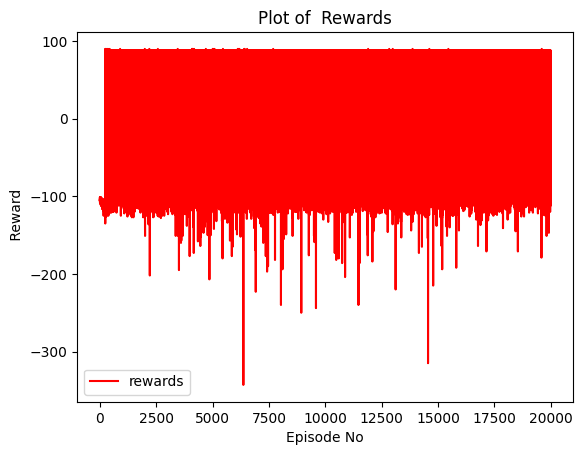

In [9]:
def  init_q_table(n_states,n_states2, n_actions):
    return np.zeros((n_states,n_states2,n_actions))
def q_update(Q, s1,s2, a, r, s_next1,s_next2, alpha, gamma):
    Q[s1][s2][a]= Q[s1][s2][a] +  alpha*(r+ gamma*np.max(Q[s_next1][s_next2])-Q[s1][s2][a])
    return Q
def select_action(Q,state1,state2, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(Q[state1][state2]) # Exploit
alpha=0.3

total_rewards=[]
Q_table=init_q_table(150,150,4)
for episode in range(EpisodeNum):
    obs,info=env.reset()
    state1=obs[0]*4+obs[1]
    state2=obs[2]*4+obs[3]
    done =False
    episode_rewards=0
    while not done:
        action=select_action(Q_table,state1,state2,epsilon)
        next_obs,reward,terminated,truncated,info=env.step(action)
        next_state1=next_obs[0]*4+next_obs[1]
        next_state2=next_obs[2]*4+next_obs[3]
        Q_table=q_update(Q_table,state1,state2,action,reward,next_state1,next_state2,alpha,discount)
        done=terminated 
        state1=next_state1
        state2=next_state2
        episode_rewards+=reward
    # print("Episode "+str(episode+1)+" Done")
    total_rewards.append(episode_rewards)
    epsilon = max(epsilon_min, epsilon_decay * epsilon)

done =False
obs,info=env.reset()
env.render()
state1=obs[0]*4+obs[1]
state2=obs[2]*4+obs[3]
while not done:
    action=np.argmax(Q_table[state1][state2])
    next_obs,reward,terminated,truncated,info=env.step(action)
    env.render()
    next_state1=next_obs[0]*4+next_obs[1]
    next_state2=next_obs[2]*4+next_obs[3]
    state1=next_state1
    state2=next_state2
    done=terminated

    


    
    

print(Q_table)
print(total_rewards)
x=list(range(EpisodeNum))
y=total_rewards
plt.plot(x,y,color='r',label='rewards')
plt.xlabel("Episode No")
plt.ylabel(" Reward")
plt.title("Plot of  Rewards")
plt.legend()
plt.show()


In [ ]:
import pickle
with open('qtable.pkl','wb') as f:
    pickle.dump(Q_table,f)

with open('qtable.pkl', 'rb') as f:
    loaded_arr = pickle.load(f)

print(loaded_arr.shape)

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
